# Low resolution simulation analyses SCF MODIS
## fig08

Original notebook: https://github.com/mickaellalande/PhD/blob/master/SCF_parameterizations/3_simulations/fig_LR_simulation_MODIS.ipynb

All analyses are in `LR_simulation_analyses_scf_MODIS.ipynb`

conda env: new `phd_v3` (in `envs/phd`)

Nudged simulations in wind at 6 hours and in temperature at 10 days, with released boundary layer. This configuration was chosen in order to compromise between not prescribing excessively the nudging close to the surface to let the ground-atmosphere coupling occur, while trying to minimize the biases of the model related to circulation and the tropospheric temperature bias observed.

Having a coupled simulation has the advantage of allowing snow-related feedbacks to emerge, while a forced ORCHIDEE simulation would largely prescribes snow. The coupling has of course advantages and disadvantages which are discussed in the article. More tests in forced version will of course be necessary with different forcing datasets to evaluate the uncertainty (however there is only a few data available over mountainous area and precipitation is often very uncertain).

Nudging is disabled in the "approximative" boundary layer (below 0.85 * surface pressure). It automatically adapts to the mountains (hybrid sigma-pressure levels; https://lmdz-forge.lmd.jussieu.fr/mediawiki/LMDZPedia/index.php/The_vertical_discretization_in_LMDZ), so for example if we are at 850 hPa at level 5 of the model when p_surf is 1000 hPa, we do not guide anywhere below level 5.

More information on nudging: 
- https://lmdz.lmd.jussieu.fr/le-coin-des-developpeurs/notes-techniques/ressources/guidage_LMDZ.pdf
- https://forge.ipsl.jussieu.fr/igcmg_doc/wiki/Doc/Models/LMDZ#Simulationwithnudging

More analyses of test simulations can be found here: https://github.com/mickaellalande/PhD/tree/master/Jean-Zay/SCA_parameterization/LMDZOR-STD

## Simulations 

- NY07: LMDZORnudge-uvt-6h-10d-noBL-STD-NY07-2004-2008
- R01: LMDZORnudge-uvt-6h-10d-noBL-STD-R01-2004-2008
- SL12: LMDZORnudge-uvt-6h-10d-noBL-STD-SL12-2004-2008
- LA22: LMDZORnudge-uvt-6h-10d-noBL-STD-LA22-2004-2008

## Path to simulations

- Jean-Zay WORK: `/gpfsdswork/projects/rech/goe/ufz23bm/SCA_parameterization/modipsl/config/LMDZOR_v6/`
- Jean-Zay STORE: `/gpfsstore/rech/goe/ufz23bm/IGCM_OUT/LMDZOR/DEVT/amip/`
- THREDDS: `/gpfsdsmnt/ipsl/dods/pub/ufz23bm/LMDZOR/DEVT/amip/`
- CICLAD: `/thredds/idris/work/ufz23bm/LMDZOR/DEVT/amip/` 
- local: `~/Dropbox/data/IGCM_OUT/LMDZOR/DEVT/amip/`
- https://vesg.ipsl.upmc.fr/thredds/catalog/idris_work/ufz23bm/LMDZOR/DEVT/amip/

## Import modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
plot.rc['abc.style'] = '(a)' # for EGU journals (only abc in new proplot versions)
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
import calendar

import sys
sys.path.insert(1, '../utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

import warnings
warnings.filterwarnings("ignore")

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]
Virtual memory usage - total: 31 GB / available: 24 GB / percent used: 21.1 %


## Define paths

In [2]:
# root = '/thredds/idris/work/ufz23bm/LMDZOR/DEVT/amip/' # CICLAD
root = '/home/lalandmi/Dropbox/data/IGCM_OUT/LMDZOR/DEVT/amip/' # local

exp_NY07 = 'LMDZORnudge-uvt-6h-10d-noBL-STD-NY07-2004-2008'
exp_R01 = 'LMDZORnudge-uvt-6h-10d-noBL-STD-R01-2004-2008'
exp_SL12 = 'LMDZORnudge-uvt-6h-10d-noBL-STD-SL12-2004-2008'
exp_LA22 = 'LMDZORnudge-uvt-6h-10d-noBL-STD-LA22-2004-2008'

# 1 year spin-up
period = slice('2005', '2008')

## Load model data

In [3]:
scf_NY07 = xr.open_dataset(root+exp_NY07+'/SRF/Analyse/TS_MO/'+exp_NY07+'_20040101_20081231_1M_frac_snow.nc').frac_snow.rename({'time_counter': 'time'}).sortby('lat').sel(time=period)
scf_R01 = xr.open_dataset(root+exp_R01+'/SRF/Analyse/TS_MO/'+exp_R01+'_20040101_20081231_1M_frac_snow.nc').frac_snow.rename({'time_counter': 'time'}).sortby('lat').sel(time=period)
scf_SL12 = xr.open_dataset(root+exp_SL12+'/SRF/Analyse/TS_MO/'+exp_SL12+'_20040101_20081231_1M_frac_snow.nc').frac_snow.rename({'time_counter': 'time'}).sortby('lat').sel(time=period)
scf_LA22 = xr.open_dataset(root+exp_LA22+'/SRF/Analyse/TS_MO/'+exp_LA22+'_20040101_20081231_1M_frac_snow.nc').frac_snow.rename({'time_counter': 'time'}).sortby('lat').sel(time=period)

tas_NY07 = xr.open_dataset(root+exp_NY07+'/ATM/Analyse/TS_MO/'+exp_NY07+'_20040101_20081231_1M_t2m.nc').t2m.rename({'time_counter': 'time'}).sortby('lat').sel(time=period) - 273.15 # °C
tas_R01 = xr.open_dataset(root+exp_R01+'/ATM/Analyse/TS_MO/'+exp_R01+'_20040101_20081231_1M_t2m.nc').t2m.rename({'time_counter': 'time'}).sortby('lat').sel(time=period) - 273.15 # °C
tas_SL12 = xr.open_dataset(root+exp_SL12+'/ATM/Analyse/TS_MO/'+exp_SL12+'_20040101_20081231_1M_t2m.nc').t2m.rename({'time_counter': 'time'}).sortby('lat').sel(time=period) - 273.15 # °C
tas_LA22 = xr.open_dataset(root+exp_LA22+'/ATM/Analyse/TS_MO/'+exp_LA22+'_20040101_20081231_1M_t2m.nc').t2m.rename({'time_counter': 'time'}).sortby('lat').sel(time=period) - 273.15 # °C

## Load observations

In [4]:
snc_MODIS_1deg = xr.open_mfdataset('/home/lalandmi/Dropbox/data/ESA_CCI_SNOW/preprocess/scfg/MODIS/v2.0/monthly_1deg/*.nc')['scfg_interp_1deg_icefilled'].sel(time=period)
snc_MODIS_1deg['time'] = scf_NY07.time
snc_AVHRR_1deg = xr.open_mfdataset('/home/lalandmi/Dropbox/data/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly_1deg/*.nc')['scfg_interp_1deg_icefilled'].sel(time=period)
snc_AVHRR_1deg['time'] = scf_NY07.time
tas_CRU = xr.open_dataset('~/Dropbox/data/CRU/cru_ts4.00.1901.2015.tmp.dat.nc').tmp.sel(time=period)
tas_CRU['time'] = scf_NY07.time

## Regrid obs to model

In [5]:
regridder = xe.Regridder(snc_MODIS_1deg, scf_NY07, 'bilinear', periodic=True, reuse_weights=True)
snc_MODIS_1deg_regrid = regridder(snc_MODIS_1deg)
snc_AVHRR_1deg_regrid = regridder(snc_AVHRR_1deg)

regridder = xe.Regridder(tas_CRU, scf_NY07, 'bilinear', periodic=True, reuse_weights=True)
tas_CRU_regrid = regridder(tas_CRU)

Reuse existing file: bilinear_180x360_143x144_peri.nc
Reuse existing file: bilinear_360x720_143x144_peri.nc


## Load topo

In [6]:
grid_LR = xr.open_dataset('/home/lalandmi/Dropbox/data/IGCM_OUT/ELI-144x142x79-GMTED-STD-amip_2004_grilles_gcm.nc')

topo_LR = u.phys2dyn(xr.open_dataset('/home/lalandmi/Dropbox/data/IGCM_OUT/ELI-144x142x79-GMTED-STD-amip_2004_startphy.nc').ZMEA_NOT_FILTERED, grid_LR)
std_LR = u.phys2dyn(xr.open_dataset('/home/lalandmi/Dropbox/data/IGCM_OUT/ELI-144x142x79-GMTED-STD-amip_2004_startphy.nc').ZSTD_NOT_FILTERED, grid_LR)

# To have same lon from -180 to 180
regridder = xe.Regridder(topo_LR, scf_NY07, 'bilinear', periodic=True, reuse_weights=True)
topo_LR_regrid = regridder(topo_LR)
std_LR_regrid = regridder(std_LR)

Reuse existing file: bilinear_143x144_143x144_peri.nc


## Plot

In [7]:
lat_slice_HMA, lon_slice_HMA = u.get_domain_HMA()

# Zones
latlim_SA = slice(-60, -10); lonlim_SA = slice(-80, -60)
latlim_US = slice(20, 70); lonlim_US = slice(-165, -85)
latlim_EU = slice(30, 80); lonlim_EU = slice(0, 20)
latlim_HMA = slice(20, 55); lonlim_HMA = slice(60, 116)

In [13]:
snc_MODIS_1deg_regrid_seas = snc_MODIS_1deg_regrid.groupby('time.season').mean('time')

params = ['NY07', 'R01', 'SL12', 'LA23']
for i, da in enumerate([scf_NY07, scf_R01, scf_SL12, scf_LA22]):
    da.name = params[i]
    if i == 0:
        ds_scf_params = da.groupby('time.season').mean('time').to_dataset()
    else:
        ds_scf_params[params[i]] = da.groupby('time.season').mean('time')

In [9]:
def compute_metrics(model, obs):
    mb = (model-obs).weighted(np.cos(np.deg2rad(model.lat))).mean().values.item(0)
    rmse = np.sqrt(((model-obs)**2).weighted(np.cos(np.deg2rad(model.lat))).mean().values.item(0))
    
    x = model.where(obs*0 == 0).values.flatten(); y = obs.where(model*0 == 0).values.flatten()
    x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
    r = stats.pearsonr(x, y)
    
    return mb, rmse, r

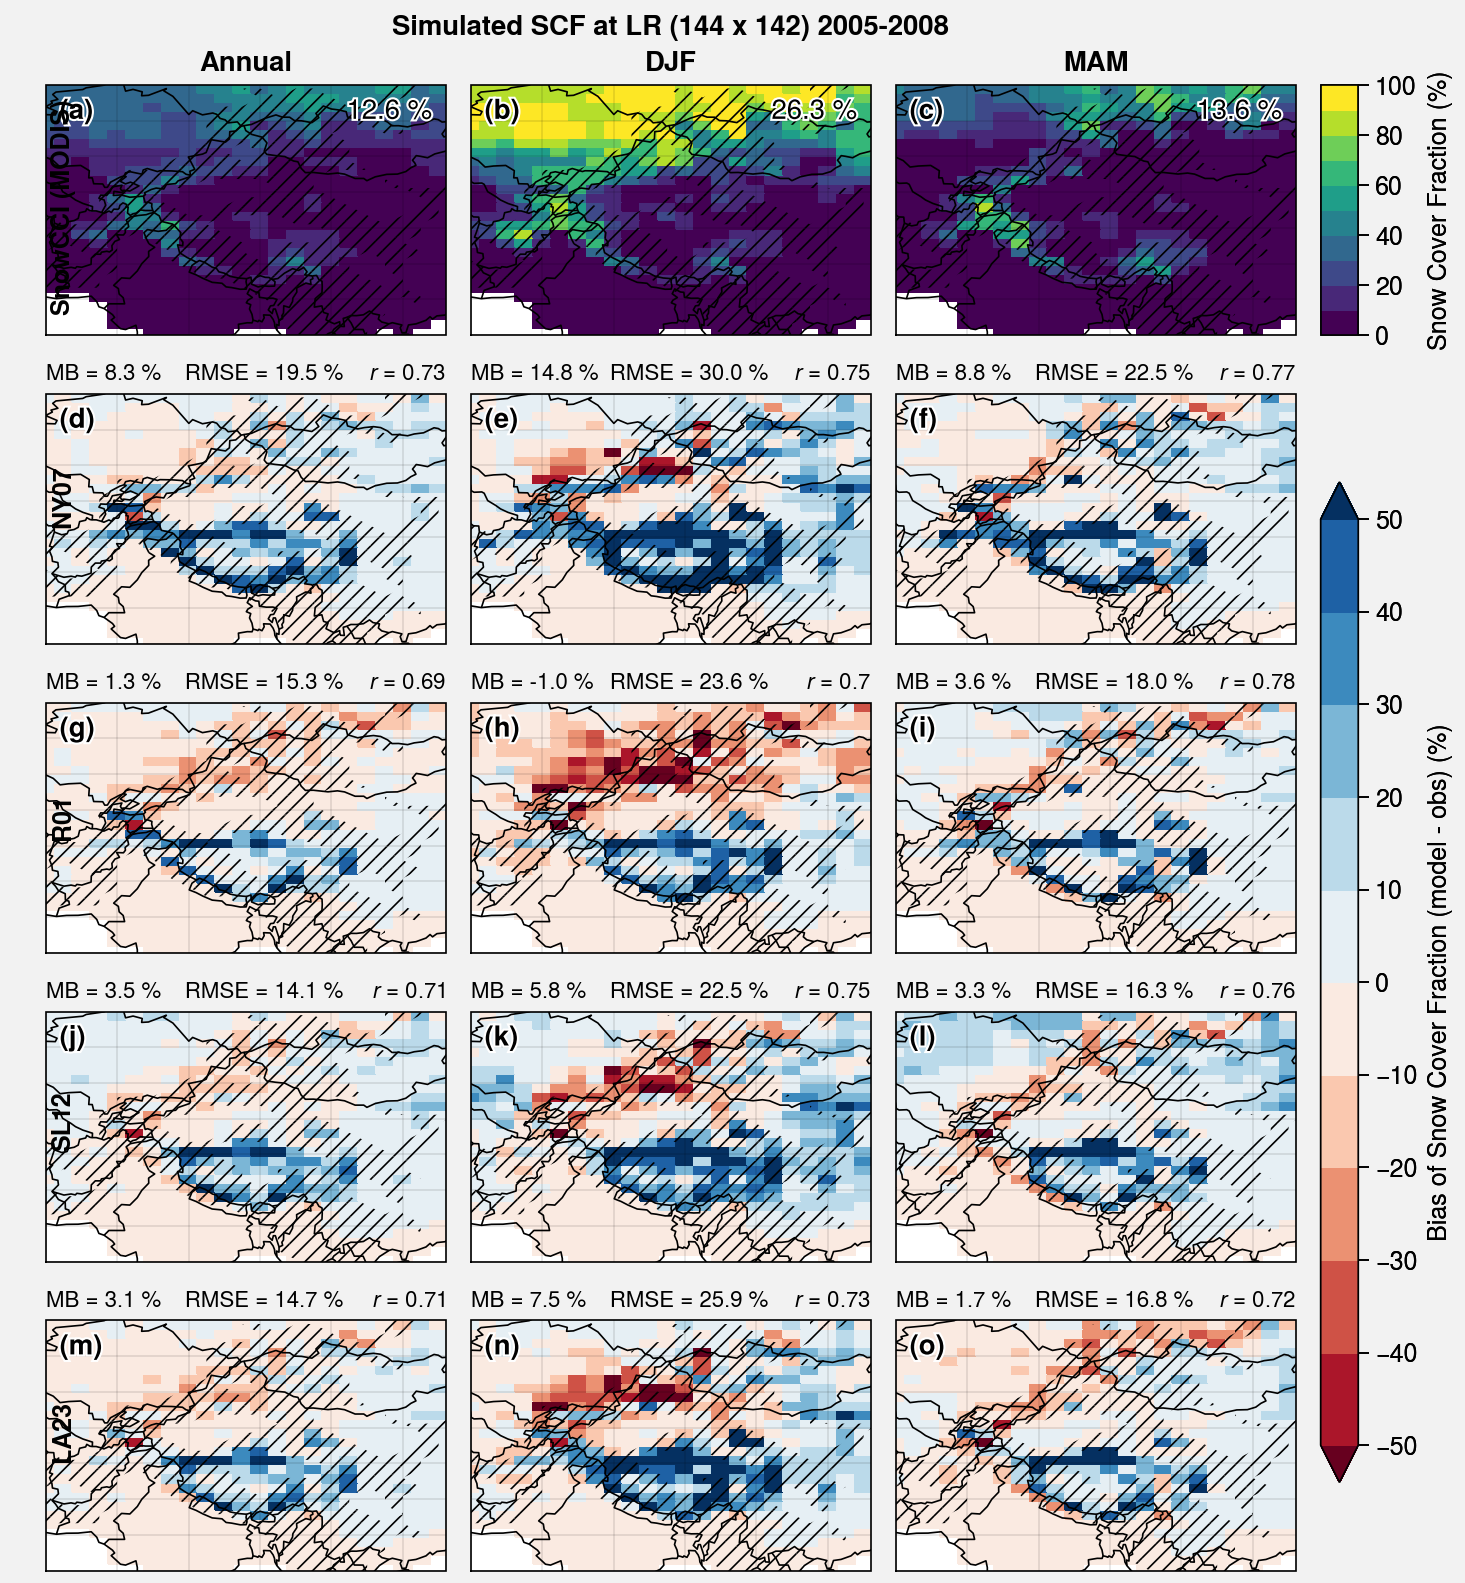

In [14]:
fig, axs = plot.subplots(ncols=3, nrows=5, proj='cyl', axwidth=2)

cmap = 'viridis'
levels = plot.arange(0, 100, 10)

cmap_bias = 'RdBu'
levels_bias = plot.arange(-50, 50, 10)
extend_bias = 'both'

threshold = 200 # STD

obs = snc_MODIS_1deg_regrid_seas.sel(lat=latlim_HMA, lon=lonlim_HMA).mean('season')
m = axs[0].pcolormesh(snc_MODIS_1deg_regrid_seas.mean('season'), cmap=cmap, levels=levels)
mean = obs.where(std_LR_regrid > threshold).weighted(np.cos(np.deg2rad(obs.lat))).mean().values.item(0)
axs[0].format(urtitle='{:.1f} %'.format(mean))

obs = snc_MODIS_1deg_regrid_seas.sel(lat=latlim_HMA, lon=lonlim_HMA, season='DJF')
axs[1].pcolormesh(obs, cmap=cmap, levels=levels)
mean = obs.where(std_LR_regrid > threshold).weighted(np.cos(np.deg2rad(obs.lat))).mean().values.item(0)
axs[1].format(urtitle='{:.1f} %'.format(mean))

obs = snc_MODIS_1deg_regrid_seas.sel(lat=latlim_HMA, lon=lonlim_HMA, season='MAM')
axs[2].pcolormesh(obs, cmap=cmap, levels=levels)
mean = obs.where(std_LR_regrid > threshold).weighted(np.cos(np.deg2rad(obs.lat))).mean().values.item(0)
axs[2].format(urtitle='{:.1f} %'.format(mean))

k = 3
for param in params:
    # Annual
    model = ds_scf_params[param].sel(lat=latlim_HMA, lon=lonlim_HMA).mean('season')
    obs = snc_MODIS_1deg_regrid_seas.sel(lat=latlim_HMA, lon=lonlim_HMA).mean('season')
    m_bias = axs[k].pcolormesh(model - obs, cmap=cmap_bias, levels=levels_bias, extend=extend_bias)
    mb, rmse, (r, _) = compute_metrics(model.where(std_LR_regrid > threshold), obs.where(std_LR_regrid > threshold))
    axs[k].format(ltitle='MB = {:.1f} %'.format(mb), ctitle='      RMSE = {:.1f} %'.format(rmse), rtitle='$\it{r}$'+' = {:.2}'.format(r), titlesize=8)
    
    # DJF
    model = ds_scf_params[param].sel(lat=latlim_HMA, lon=lonlim_HMA, season='DJF')
    obs = snc_MODIS_1deg_regrid_seas.sel(lat=latlim_HMA, lon=lonlim_HMA, season='DJF')
    axs[k+1].pcolormesh(model - obs, cmap=cmap_bias, levels=levels_bias, extend=extend_bias)
    mb, rmse, (r, _) = compute_metrics(model.where(std_LR_regrid > threshold), obs.where(std_LR_regrid > threshold))
    axs[k+1].format(ltitle='MB = {:.1f} %'.format(mb), ctitle='      RMSE = {:.1f} %'.format(rmse), rtitle='$\it{r}$'+' = {:.2}'.format(r), titlesize=8)
    
    # MAM
    model = ds_scf_params[param].sel(lat=latlim_HMA, lon=lonlim_HMA, season='MAM')
    obs = snc_MODIS_1deg_regrid_seas.sel(lat=latlim_HMA, lon=lonlim_HMA, season='MAM')
    axs[k+2].pcolormesh(model - obs, cmap=cmap_bias, levels=levels_bias, extend=extend_bias)
    mb, rmse, (r, _) = compute_metrics(model.where(std_LR_regrid > threshold), obs.where(std_LR_regrid > threshold))
    axs[k+2].format(ltitle='MB = {:.1f} %'.format(mb), ctitle='      RMSE = {:.1f} %'.format(rmse), rtitle='$\it{r}$'+' = {:.2}'.format(r), titlesize=8)
    
    k += 3
    
for ax in axs:
#     ax.contour(std_LR_regrid, levels=[200], color='red')
    ax.contourf(std_LR_regrid.where(std_LR_regrid > threshold), hatches=['////'], alpha=0)

# axs[1].colorbar(m, label='Snow Cover Fraction [%]', loc='b', ticks=20)
# fig.colorbar(m_bias, label='Bias of Snow Cover Fraction (model - obs) [%]', cols=(1, 3), length=0.6, loc='b', ticks=10)

fig.colorbar(m, label='Snow Cover Fraction (%)', row=1)
fig.colorbar(m_bias, label='Bias of Snow Cover Fraction (model - obs) (%)', rows=(2,5), length=0.85)


for pos, label in zip(np.append(np.linspace(0.08, 0.67, 4), 0.805), params[::-1] + ['SnowCCI (MODIS)']):
    fig.text(0.035, pos, label, fontweight='bold', rotation='vertical')

axs.format(
    latlim=(latlim_HMA.start, latlim_HMA.stop), lonlim=(lonlim_HMA.start, lonlim_HMA.stop),
    collabels = ['Annual', 'DJF', 'MAM'],
#     rowlabels = ['SnowCCI\n(MODIS)'] + params,
    borders=True, coast=True, labels=False, 
    abc=True, abcloc='ul',
    suptitle='Simulated SCF at LR (144 x 142) '+str(period.start)+'-'+str(period.stop) 
)

for ext in ['jpg']:
    fig.save('img/fig08.'+ext)

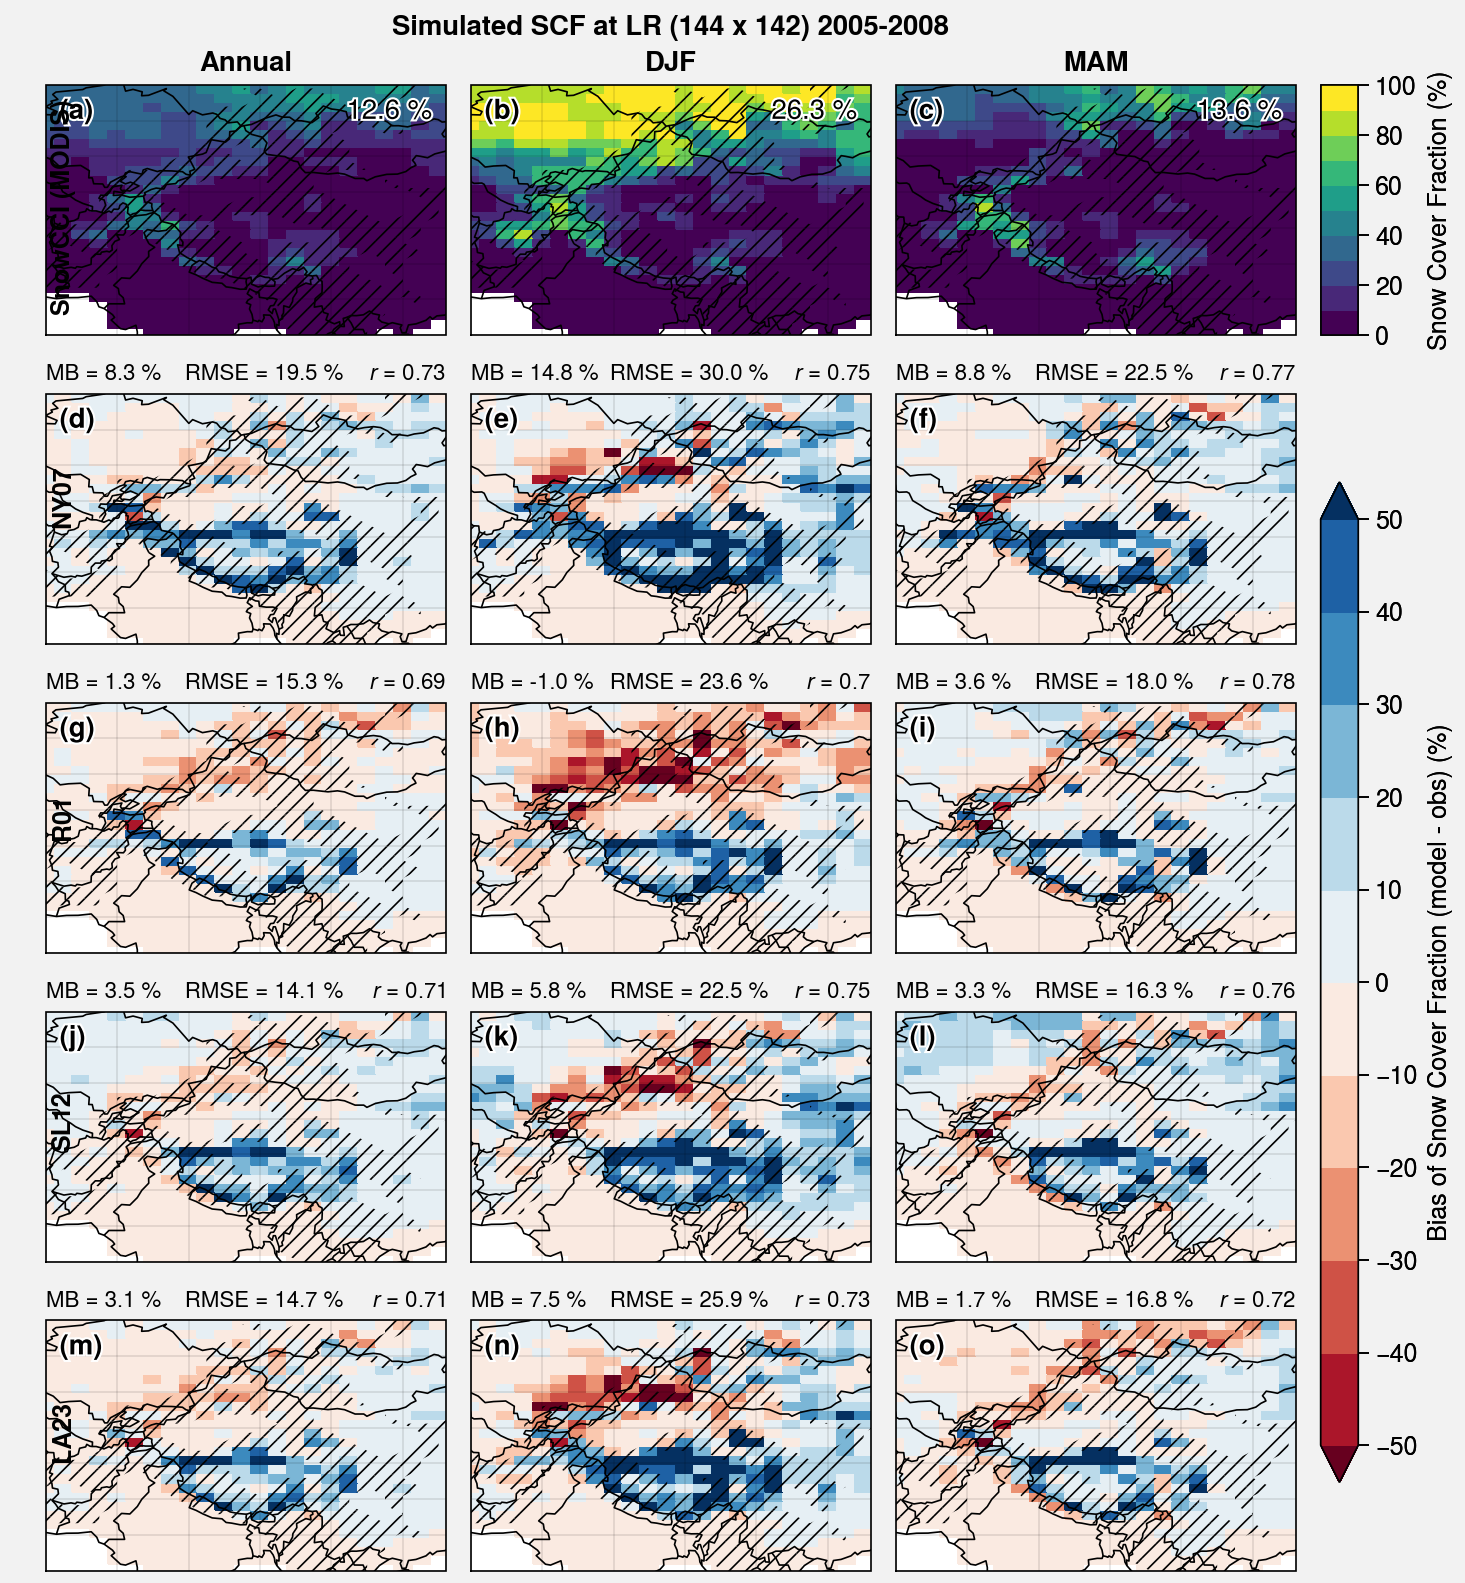

In [22]:
fig, axs = plot.subplots(ncols=3, nrows=5, proj='cyl', axwidth=2)

cmap = 'viridis'
levels = plot.arange(0, 100, 10)

cmap_bias = 'RdBu'
levels_bias = plot.arange(-50, 50, 10)
extend_bias = 'both'

threshold = 200 # STD

obs = snc_MODIS_1deg_regrid_seas.sel(lat=latlim_HMA, lon=lonlim_HMA).mean('season')
m = axs[0].pcolormesh(snc_MODIS_1deg_regrid_seas.mean('season'), cmap=cmap, levels=levels, rasterized=True)
mean = obs.where(std_LR_regrid > threshold).weighted(np.cos(np.deg2rad(obs.lat))).mean().values.item(0)
axs[0].format(urtitle='{:.1f} %'.format(mean))

obs = snc_MODIS_1deg_regrid_seas.sel(lat=latlim_HMA, lon=lonlim_HMA, season='DJF')
axs[1].pcolormesh(obs, cmap=cmap, levels=levels, rasterized=True)
mean = obs.where(std_LR_regrid > threshold).weighted(np.cos(np.deg2rad(obs.lat))).mean().values.item(0)
axs[1].format(urtitle='{:.1f} %'.format(mean))

obs = snc_MODIS_1deg_regrid_seas.sel(lat=latlim_HMA, lon=lonlim_HMA, season='MAM')
axs[2].pcolormesh(obs, cmap=cmap, levels=levels, rasterized=True)
mean = obs.where(std_LR_regrid > threshold).weighted(np.cos(np.deg2rad(obs.lat))).mean().values.item(0)
axs[2].format(urtitle='{:.1f} %'.format(mean))

k = 3
for param in params:
    # Annual
    model = ds_scf_params[param].sel(lat=latlim_HMA, lon=lonlim_HMA).mean('season')
    obs = snc_MODIS_1deg_regrid_seas.sel(lat=latlim_HMA, lon=lonlim_HMA).mean('season')
    m_bias = axs[k].pcolormesh(model - obs, cmap=cmap_bias, levels=levels_bias, extend=extend_bias, rasterized=True)
    mb, rmse, (r, _) = compute_metrics(model.where(std_LR_regrid > threshold), obs.where(std_LR_regrid > threshold))
    axs[k].format(ltitle='MB = {:.1f} %'.format(mb), ctitle='      RMSE = {:.1f} %'.format(rmse), rtitle='$\it{r}$'+' = {:.2}'.format(r), titlesize=8)
    
    # DJF
    model = ds_scf_params[param].sel(lat=latlim_HMA, lon=lonlim_HMA, season='DJF')
    obs = snc_MODIS_1deg_regrid_seas.sel(lat=latlim_HMA, lon=lonlim_HMA, season='DJF')
    axs[k+1].pcolormesh(model - obs, cmap=cmap_bias, levels=levels_bias, extend=extend_bias, rasterized=True)
    mb, rmse, (r, _) = compute_metrics(model.where(std_LR_regrid > threshold), obs.where(std_LR_regrid > threshold))
    axs[k+1].format(ltitle='MB = {:.1f} %'.format(mb), ctitle='      RMSE = {:.1f} %'.format(rmse), rtitle='$\it{r}$'+' = {:.2}'.format(r), titlesize=8)
    
    # MAM
    model = ds_scf_params[param].sel(lat=latlim_HMA, lon=lonlim_HMA, season='MAM')
    obs = snc_MODIS_1deg_regrid_seas.sel(lat=latlim_HMA, lon=lonlim_HMA, season='MAM')
    axs[k+2].pcolormesh(model - obs, cmap=cmap_bias, levels=levels_bias, extend=extend_bias, rasterized=True)
    mb, rmse, (r, _) = compute_metrics(model.where(std_LR_regrid > threshold), obs.where(std_LR_regrid > threshold))
    axs[k+2].format(ltitle='MB = {:.1f} %'.format(mb), ctitle='      RMSE = {:.1f} %'.format(rmse), rtitle='$\it{r}$'+' = {:.2}'.format(r), titlesize=8)
    
    k += 3
    
for ax in axs:
#     ax.contour(std_LR_regrid, levels=[200], color='red')
    ax.contourf(std_LR_regrid.where(std_LR_regrid > threshold), hatches=['////'], alpha=0)

# axs[1].colorbar(m, label='Snow Cover Fraction [%]', loc='b', ticks=20)
# fig.colorbar(m_bias, label='Bias of Snow Cover Fraction (model - obs) [%]', cols=(1, 3), length=0.6, loc='b', ticks=10)

fig.colorbar(m, label='Snow Cover Fraction (%)', row=1)
fig.colorbar(m_bias, label='Bias of Snow Cover Fraction (model - obs) (%)', rows=(2,5), length=0.85)


for pos, label in zip(np.append(np.linspace(0.08, 0.67, 4), 0.805), params[::-1] + ['SnowCCI (MODIS)']):
    fig.text(0.035, pos, label, fontweight='bold', rotation='vertical')

axs.format(
    latlim=(latlim_HMA.start, latlim_HMA.stop), lonlim=(lonlim_HMA.start, lonlim_HMA.stop),
    collabels = ['Annual', 'DJF', 'MAM'],
#     rowlabels = ['SnowCCI\n(MODIS)'] + params,
    borders=True, coast=True, labels=False, 
    abc=True, abcloc='ul',
    suptitle='Simulated SCF at LR (144 x 142) '+str(period.start)+'-'+str(period.stop) 
)

for ext in ['pdf']:
    fig.save('img/fig08.'+ext)